Vamos a crear una red neuronal que sea capaz de clasificar de forma binaria si un correo es spam o no lo es

In [1]:
#IMPORTS
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import seaborn as sns
import math
import matplotlib.pyplot as plt


from tensorflow import keras
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

In [2]:
%load_ext tensorboard 

## Preparación y visualización de los datos

In [3]:
data=pd.read_csv('../input/email-spam-classification-dataset-csv/emails.csv')
data.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [4]:
#Eliminamos la columna email:
data.drop(["Email No."],axis=1,inplace=True)

#Debemos ahora investigar sobre la cantidad de NaN que tenemos
data.columns[data.isnull().any()]

Index([], dtype='object')

Por suerte no disponemos de ninguna columna con valores vacíos, luego eso nos facilita mucho las cosas.
También hemos eliminado la columna email ya que es un índice que molestaba.

Echamos ahora un vistazo a ver como se distribuyen de manera estadística las variables y ver si alguna no aparece y así nos damos cuenta de que no es numérica.

In [5]:
data.describe()

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
count,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,...,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000
mean,6.640565,6.188128,5.143852,3.075599,3.124710,2.627030,55.517401,2.466551,2.024362,10.600155,...,0.005027,0.012568,0.010634,0.098028,0.004254,0.006574,0.004060,0.914733,0.006961,0.290023
std,11.745009,9.534576,14.101142,6.045970,4.680522,6.229845,87.574172,4.314444,6.967878,19.281892,...,0.105788,0.199682,0.116693,0.569532,0.096252,0.138908,0.072145,2.780203,0.098086,0.453817
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,12.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,1.000000,1.000000,2.000000,1.000000,28.000000,1.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,7.000000,4.000000,3.000000,4.000000,2.000000,62.250000,3.000000,1.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,210.000000,132.000000,344.000000,89.000000,47.000000,77.000000,1898.000000,70.000000,167.000000,223.000000,...,4.000000,7.000000,2.000000,12.000000,3.000000,4.000000,3.000000,114.000000,4.000000,1.000000


## Selección de variables
Como tenemos muchas columnas el ordenador va a tardar demasiado. Por lo que vamos a aplicar PCA con una varianza explicativa del 70% para reducir la dimensionalidad

In [6]:
x_=data.iloc[:,:-1]
normal=StandardScaler()
x_=normal.fit_transform(x_)

pca_var= PCA(n_components=0.7, svd_solver='full')

X_pca = pca_var.fit_transform(x_)
X_pca.shape

(5172, 309)

In [7]:
min_var = 0.7    # Varianza mín. a preservar

pca_var= PCA(n_components=min_var, svd_solver='full')

X_pca2 = pca_var.fit(x_)

print('Nº de componentes:', len(X_pca2.components_))
print('Ratio de varianza explicada:')
print(X_pca2.explained_variance_ratio_)

Nº de componentes: 309
Ratio de varianza explicada:
[0.07181724 0.02393477 0.01537363 0.0130559  0.01198736 0.01122417
 0.00993453 0.0095416  0.00848721 0.00789056 0.00732223 0.00705226
 0.00639642 0.00605365 0.00590974 0.00566777 0.00559672 0.00553174
 0.00529718 0.00509747 0.00505381 0.00476423 0.00465053 0.00444924
 0.00426842 0.00421941 0.00408709 0.00398178 0.00389677 0.00380031
 0.00375309 0.00359757 0.00357718 0.00350277 0.00343986 0.00335709
 0.00329503 0.00328796 0.00324901 0.00317379 0.00313284 0.00310412
 0.00305739 0.00303361 0.00299838 0.00295039 0.00292866 0.00290814
 0.00285953 0.00282347 0.0027766  0.00275929 0.00269387 0.00268407
 0.0026471  0.00259389 0.00257838 0.00254471 0.00251263 0.00248937
 0.00247231 0.00243835 0.00242549 0.00236972 0.00235033 0.00232327
 0.00231985 0.0022993  0.00228721 0.00225772 0.00223772 0.00223033
 0.0022106  0.00218653 0.00216964 0.00214117 0.00213162 0.00211678
 0.00211458 0.00208925 0.00207298 0.00206966 0.00205746 0.00202857
 0.0020224

vamos ahora a preparar los datos para que puedan ser utilizados por nuestros algoritmos

In [8]:
#Separación de los conjuntos
x_train,x_test,y_train,y_test=train_test_split(X_pca,
                                               data.iloc[:,-1],test_size=0.1, random_state=95134)

#Preparación para trabajar con tensorflow
X_train=tf.convert_to_tensor(x_train,np.float32)
y_train=tf.convert_to_tensor(y_train,np.int8)

X_test=tf.convert_to_tensor(x_test,np.float32)
y_test=tf.convert_to_tensor(y_test,np.int8)

2022-03-09 11:57:41.925341: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Creación y entrenamiento del modelo

In [9]:
#Definición de los layers
layers=[keras.layers.Flatten(input_shape=(309,)),
        keras.layers.Dense(500, activation=tf.nn.relu),
        keras.layers.Dense(800, activation=tf.nn.relu),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)]

#Definición del modelo de tipo Secuencial
model=keras.Sequential(layers,name="ClasificacionBinaria")

model.summary()

model.compile(optimizer="sgd",
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "ClasificacionBinaria"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 309)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               155000    
_________________________________________________________________
dense_1 (Dense)              (None, 800)               400800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 801       
Total params: 556,601
Trainable params: 556,601
Non-trainable params: 0
_________________________________________________________________


In [10]:
tensorboard_callback= TensorBoard(log_dir="logs")

model.fit(
    X_train,
    y_train,
    epochs=100, 
    batch_size=1200, 
    validation_split=0.08, 
    callbacks=[tensorboard_callback])

2022-03-09 11:57:42.613711: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-09 11:57:42.613885: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-09 11:57:42.615170: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-09 11:57:42.712428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
3/4 [=====================>........] - ETA: 0s - loss: 0.7565 - binary_accuracy: 0.5622

2022-03-09 11:57:43.469496: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-09 11:57:43.469665: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-09 11:57:43.510354: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-09 11:57:43.515857: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-09 11:57:43.523023: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_03_09_11_57_43

2022-03-09 11:57:43.524104: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_09_11_57_43/d02916a8d1e4.trace.json.gz
2022-03-09 11:57:43.537026: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_03_09_11_57_43

2022-03-09 11:57:43.537784: I

4/4 [==============================] - 1s 125ms/step - loss: 0.7299 - binary_accuracy: 0.5891 - val_loss: 0.6312 - val_binary_accuracy: 0.7078
Epoch 2/100
4/4 [==============================] - 0s 45ms/step - loss: 0.5798 - binary_accuracy: 0.7286 - val_loss: 0.5731 - val_binary_accuracy: 0.7239
Epoch 3/100
4/4 [==============================] - 0s 45ms/step - loss: 0.5298 - binary_accuracy: 0.7470 - val_loss: 0.5359 - val_binary_accuracy: 0.7373
Epoch 4/100
4/4 [==============================] - 0s 45ms/step - loss: 0.4935 - binary_accuracy: 0.7629 - val_loss: 0.5079 - val_binary_accuracy: 0.7587
Epoch 5/100
4/4 [==============================] - 0s 44ms/step - loss: 0.4672 - binary_accuracy: 0.7725 - val_loss: 0.4872 - val_binary_accuracy: 0.7587
Epoch 6/100
4/4 [==============================] - 0s 44ms/step - loss: 0.4459 - binary_accuracy: 0.7865 - val_loss: 0.4694 - val_binary_accuracy: 0.7775
Epoch 7/100
4/4 [==============================] - 0s 45ms/step - loss: 0.4284 - binary

## Evaluación y comprobación de resultados

In [11]:
#Hará la evaluación según la métrica y función de loss entrenada
test_loss,test_acc= model.evaluate(X_test,y_test)
print(test_loss)
print(test_acc)

17/17 [==============================] - 0s 2ms/step - loss: 0.1714 - binary_accuracy: 0.9556
0.1714000254869461
0.9555984735488892


In [12]:
%tensorboard --logdir logs

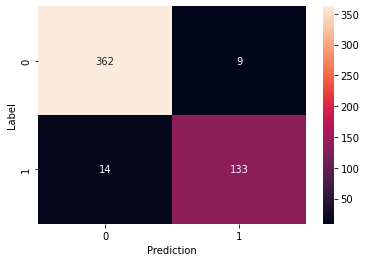

In [13]:
confusion_mtx=tf.math.confusion_matrix(
    y_test, tf.math.round(model.predict(X_test)) )

sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [14]:
#Ponemos el valor real y el valor predicho en la misma dimensión 
actual = y_test
predicted = tf.math.round(model.predict(X_test))
predicted=tf.cast(predicted,tf.int64)
predicted=predicted.numpy().reshape(518)

VP = tf.math.count_nonzero(predicted * actual,dtype=tf.float32)
VN = tf.math.count_nonzero((predicted - 1) * (actual - 1),dtype=tf.float32)
FP = tf.math.count_nonzero(predicted * (actual - 1),dtype=tf.float32)
FN = tf.math.count_nonzero((predicted - 1) * actual,dtype=tf.float32)

#Exactitud
print('\nExactitud:',(VN+VP)/(VP+VN+FP+FN))

#Ratio de error
print('\nRatio de Error:',(FN+FP)/(VP+VN+FP+FN))

#Precisión
print('\nPrecisión', VP/(VP+FP))
P=VP/(VP+FP)
#Recall
print('\nRecall',VP/(VP+FN))
R=VP/(VP+FN)
#Especificidad
print("\nEspecifidad", VN/(VN+FP))

#F1-Score
print("\nf1-score",2*(P*R)/(P+R))

#FB-Score
print('\nfb_Score',(1+0.7*0.7)*(P*R)/((0.7*P)+R))


Exactitud: tf.Tensor(0.9555985, shape=(), dtype=float32)

Ratio de Error: tf.Tensor(0.044401545, shape=(), dtype=float32)

Precisión tf.Tensor(0.9366197, shape=(), dtype=float32)

Recall tf.Tensor(0.9047619, shape=(), dtype=float32)

Especifidad tf.Tensor(0.97574127, shape=(), dtype=float32)

f1-score tf.Tensor(0.9204152, shape=(), dtype=float32)

fb_Score tf.Tensor(0.8091875, shape=(), dtype=float32)


Hemos reducido significativamente la dimensión del problema y hemos obtenido a pesar de usar solo un 70% de la varianza una accuracy del 0.97 y un valor de función de loss pequeño. Por lo que hemos resuelto bien el problema del spam.